# Tutorial: Ensemble Learning

In this tutorial, we will implement a basic method for ensemble learning - bagging. The term "bagging" stands for bootstrapped aggregating as we use bootstrapping to crete variations of our original training data to train multiple models on. The outputs of all models are then aggregated, e.g., by averaging or by voting. As always, we'll start off by importing everything we'll need, setting our random seed and creating our data.

In [9]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score

RANDOM_SEED = 42
N = 500

rng = np.random.default_rng(RANDOM_SEED)

# load and split the data set
X_data, y_data = make_moons(n_samples=N, noise=0.3, random_state=RANDOM_SEED)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=RANDOM_SEED)

### Task 1: Explore the data

Implement a plotting function to visualise the training data using `plt.scatter` using different colours and marker shapes for each class. Then answer the following questions:

1. How many classes does the data have?
2. How many samples does the training set contain?
3. Is the data linearly separable?

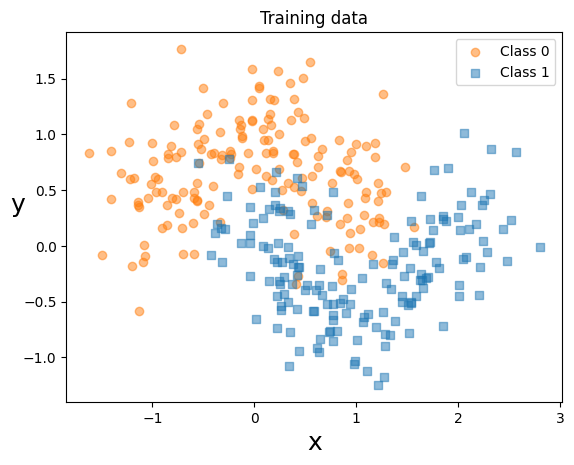

In [10]:
def plot_data(X, y, alpha=0.5):
    plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], c="tab:orange", marker="o", alpha=alpha, label="Class 0")
    plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], c="tab:blue", marker="s", alpha=alpha, label="Class 1")
    plt.xlabel("x", fontsize=18)
    plt.ylabel("y", fontsize=18, rotation=0)
    plt.title("Training data")
    plt.legend()


plt.figure()
plot_data(X_train, y_train)
plt.show()

### Task 2: Train a baseline

Next, we want to train a baseline classifier to compare our bagging classifier to. In this case, we want to use decision trees as our base classifiers, so it makes sense to use a single decision tree as our classifier. Use sklearn's implementation of decision trees `DecisionTreeClassifier` to train a classifier. Then report the classifier's accuracy and plot the decision boundary of the classifier.

Hint: To visualise the decision boundary take a look at the following functions:
- `np.linspace`
- `np.meshgrid`
- `np.column_stack`
- `plt.contour`
- `ravel`


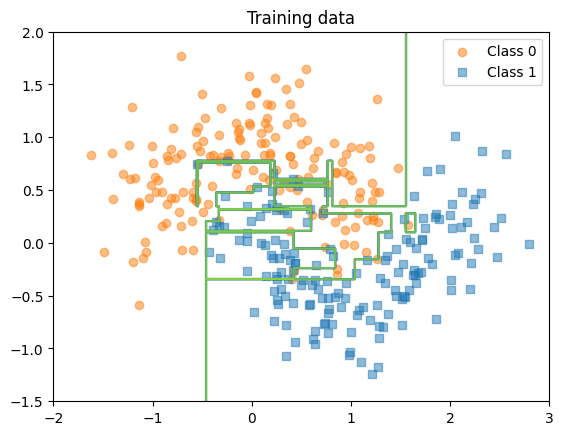

The accuracy of the baseline classifier is 0.8727


In [11]:
# use standard classifier
classifier = DecisionTreeClassifier(random_state=RANDOM_SEED)
classifier = classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred)

def plot_decision_boundary(clf, axes=[-2, 3, -1.5, 2], alpha=0.5):
    x1s = np.linspace(axes[0], axes[1], 2000)
    x2s = np.linspace(axes[2], axes[3], 2000)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.column_stack([x1.ravel(), x2.ravel()])
    y_pred = clf.predict(X_new).reshape(x1.shape)
    plt.contour(x1, x2, y_pred, alpha=alpha)
    plt.xlabel(r"", fontsize=18)
    plt.ylabel(r"", fontsize=18, rotation=0)


baseline_acc = accuracy_score(y_pred, y_test)

plt.figure()
plot_data(X_train, y_train)
plot_decision_boundary(classifier)
plt.show()

print(f"The accuracy of the baseline classifier is {baseline_acc:.4}")


### Task 3: Implement Bagging

Now, bet's finally implement the bagging algorithm. We'll follow the common sklearn interterface. Add your code to the code skeleton below. Then train a bagging classifier with 5 base classifiers, plot the decision boundary, and report the accuracy on the test set.

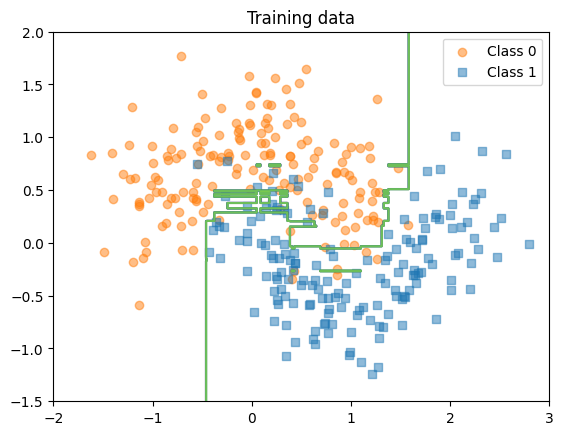

The accuracy of the bagging classifier is 0.9091


In [12]:
class BaggingClassifier():

    def __init__(self, num_classifiers: int, base_classifier=DecisionTreeClassifier, seed=RANDOM_SEED):
        self.num_classifiers = num_classifiers
        self.base_classifiers = [base_classifier(random_state=seed) for _ in range(num_classifiers)]
        self.rng = np.random.default_rng(seed)

    def fit(self, X, y, num_samples=100):
        for base_clf in self.base_classifiers:
            # bootstrap indices
            idxs = rng.choice(np.arange(X.shape[0]), num_samples, replace=True)
            # fit base classifier on bootstrapped datasets
            base_clf.fit(X[idxs],y[idxs])

    def predict(self, X):
        # get predictions of all base classifiers
        preds = np.stack([clf.predict(X) for clf in self.base_classifiers], axis=1)
        # return the label returned by the majority (this version only works for binary problems with classes 0 and 1)
        counts = np.sum(preds, axis=1)
        return counts >= .5 * self.num_classifiers

# train bagging classifier
bagging_clf = BaggingClassifier(5)
bagging_clf.fit(X_train, y_train)
bagging_pred = bagging_clf.predict(X_test)
bagging_acc = accuracy_score(bagging_pred, y_test)

# plot results
plt.figure()
plot_data(X_train, y_train)
plot_decision_boundary(bagging_clf)
plt.show()

print(f"The accuracy of the bagging classifier is {bagging_acc:.4}")


### Task 4: Experiments and evaluation

Now that we have implemented bagging, it is time to draw some meaningful conclusions. Single experiments are not sufficient to back up reliable claims. Write an experiment function to train BaggingClassifiers with k base classifiers 100 times each. Test k values from 1 to 50, then report the mean and standard deviation of the classifiers' accuracy on the test set.

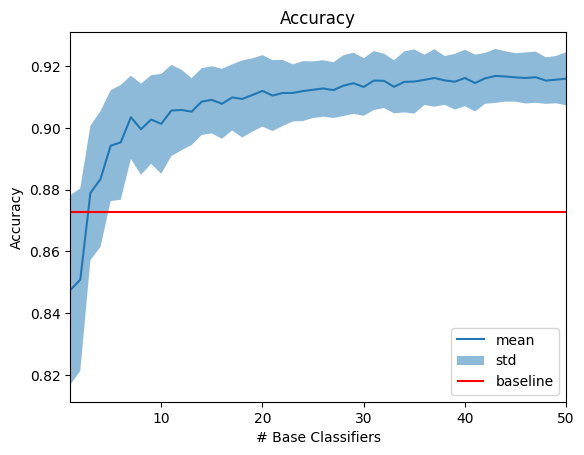

In [15]:
def run_experiments(max_k, num_runs=100):
    
    accuracies = np.zeros((50, num_runs))

    for k in range(0, max_k):
        for i in range(num_runs):
            bagging_clf = BaggingClassifier(k+1)
            bagging_clf.fit(X_train, y_train)
            bagging_pred = bagging_clf.predict(X_test)
            accuracies[k, i] = accuracy_score(bagging_pred, y_test)

    return accuracies

accs = run_experiments(50, 100)    

def plot_mean_std(x, y):

    y_mean = accs.mean(axis=1)
    y_std = accs.std(axis=1)

    plt.plot(np.arange(1,51), y_mean, label="mean")
    plt.fill_between(np.arange(1,51), y_mean+y_std, y_mean-y_std, alpha=0.5, label="std")


plt.figure()
plot_mean_std(np.arange(1, 51), accs)
plt.ylabel("Accuracy")
plt.xlabel("# Base Classifiers")
plt.title("Accuracy")
plt.hlines(baseline_acc, 0, 51, "r", label="baseline")
plt.xlim([1,50])
plt.legend(loc="lower right")
plt.show()